In [ ]:
# import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pickle
from eval_utils import cross_boundary_correctness
import matplotlib.pyplot as plt
import pandas as pd
import pyrovelocity
import time
import unitvelo as utv
from os.path import exists
from pyrovelocity.api import train_model
method = 'pyroVelocity_model2'

In [2]:
def compute_mean_vector_field(
    pos,
    adata,
    basis="umap",
    n_jobs=1,
    spliced="spliced_pyro",
    raw=False,
):
    scv.pp.neighbors(adata, use_rep="pca")

    adata.var["velocity_genes"] = True

    if spliced == "spliced_pyro":
        if raw:
            ut = pos["ut"]
            st = pos["st"]
            ut = ut / ut.sum(axis=-1, keepdims=True)
            st = st / st.sum(axis=-1, keepdims=True)
        else:
            ut = pos["ut"]
            st = pos["st"]
        adata.layers["spliced_pyro"] = st.mean(0).squeeze()
        # if ('u_scale' in pos) and ('s_scale' in pos): # TODO: two scale for Normal distribution
        if "u_scale" in pos:  # only one scale for Poisson distribution
            adata.layers["velocity_pyro"] = (
                ut * pos["beta"] / pos["u_scale"] - st * pos["gamma"]
            ).mean(0)
        else:
            if "beta_k" in pos:
                adata.layers["velocity_pyro"] = (
                    (ut * pos["beta_k"] - pos["st"] * pos["gamma_k"]).mean(0).squeeze()
                )
            else:
                adata.layers["velocity_pyro"] = (
                    ut * pos["beta"] - pos["st"] * pos["gamma"]
                ).mean(0)
        scv.tl.velocity_graph(
            adata, vkey="velocity_pyro", xkey="spliced_pyro", n_jobs=n_jobs
        )
    elif spliced in ["Ms"]:
        ut = adata.layers["Mu"]
        st = adata.layers["Ms"]
        if ("u_scale" in pos) and ("s_scale" in pos):
            adata.layers["velocity_pyro"] = (
                ut * pos["beta"] / (pos["u_scale"] / pos["s_scale"]) - st * pos["gamma"]
            ).mean(0)
        else:
            adata.layers["velocity_pyro"] = (
                ut * pos["beta"] - pos["st"] * pos["gamma"]
            ).mean(0)
        scv.tl.velocity_graph(adata, vkey="velocity_pyro", xkey="Ms", n_jobs=n_jobs)
    elif spliced in ["spliced"]:
        ut = adata.layers["unspliced"]
        st = adata.layers["spliced"]
        if ("u_scale" in pos) and ("s_scale" in pos):
            adata.layers["velocity_pyro"] = (
                ut * pos["beta"] / (pos["u_scale"] / pos["s_scale"]) - st * pos["gamma"]
            ).mean(0)
        else:
            adata.layers["velocity_pyro"] = (
                ut * pos["beta"] - pos["st"] * pos["gamma"]
            ).mean(0)
        scv.tl.velocity_graph(
            adata, vkey="velocity_pyro", xkey="spliced", n_jobs=n_jobs
        )

    scv.tl.velocity_embedding(adata, vkey="velocity_pyro", basis=basis)

In [3]:
datasets = ['MouseErythroid','Pancreas_with_cc', 'HumanDevelopingBrain', 'DentateGyrus' , 'MouseBoneMarrow', 'HumanBoneMarrow']
data_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/'
save_dir = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_results_revision/'

MouseErythroid
Filtered out 47456 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 3000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:33) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["raw_unspliced"]                                                             
INFO     Using data from adata.layers["raw_spliced"]                                                               
INFO     Successfully registered anndata object containing 9815 cells, 3000 vars,

Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 9815  │
│             Vars             │ 3000  │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                 SCVI Data Registry                 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Data       ┃      scvi-tools Location      ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        X         │  adata.layers['raw_spliced']  │
│        U         │ adata.layers['raw_unspliced'] │
│      batch       │   adata.obs['_scvi_batch']    │
│      label       │   adata.obs['_scvi_labels']   │
│      ind_x       │     adata.obs['_indices']     │
│    u_lib_size    │    adata.obs['u_lib_size']    │
│    s_lib_size    │    adata.obs['s_lib_size']    │
│ u_lib_size_mean  │ adata.obs['u_lib_size_mean']  │
│ s_lib_size_mean  │ adata.obs['s_lib_size_mean']  │
│ u_lib_size_scale │ adata.obs['u_lib_size_scale'] │
│ s_lib_size_scale │ adata.obs['s_lib_size_scale'] │
└──────────────────┴───────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                       Batch Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

-----------
auto
auto
step    0 loss = 6.76887e+08 patience = 45
step  100 loss = 4.31873e+08 patience = 45
step  200 loss = 3.85903e+08 patience = 43
step  300 loss = 3.64355e+08 patience = 43
step  400 loss = 3.53556e+08 patience = 45
step  500 loss = 3.48217e+08 patience = 31
step  600 loss = 3.45202e+08 patience = 36
step  700 loss = 3.43846e+08 patience = 26
step  800 loss = 3.4346e+08 patience = 39
step  900 loss = 3.43104e+08 patience = 35
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/64 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:01:35) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:03) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/64 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:14) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('Blood progenitors 1', 'Blood progenitors 2'): 0.9091416947436833, ('Blood progenitors 2', 'Erythroid1'): 0.8065732878768853, ('Erythroid1', 'Erythroid2'): 0.8426566899727834, ('Erythroid2', 'Erythroid3'): 0.8314463142549767}
Total Mean: 0.8474544967120822
# In-cluster Coherence
{'Blood progenitors 1': 0.80518085, 'Blood progenitors 2': 0.7254092, 'Erythroid1': 0.67482334, 'Erythroid2': 0.68407726, 'Erythroid3': 0.8362193}
Total Mean: 0.7451419830322266
Pancreas_with_cc
Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 3000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectiv

INFO:scvi.data._anndata:No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                                                 


INFO:scvi.data._anndata:No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["raw_unspliced"]                                                             


INFO:scvi.data._anndata:Using data from adata.layers["raw_unspliced"]


INFO     Using data from adata.layers["raw_spliced"]                                                               


INFO:scvi.data._anndata:Using data from adata.layers["raw_spliced"]


INFO     Successfully registered anndata object containing 3696 cells, 3000 vars, 1 batches, 1 labels, and 0       
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               


INFO:scvi.data._anndata:Successfully registered anndata object containing 3696 cells, 3000 vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                                                


INFO:scvi.data._anndata:Please do not further modify adata until model is trained.


Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 3696  │
│             Vars             │ 3000  │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                 SCVI Data Registry                 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Data       ┃      scvi-tools Location      ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        X         │  adata.layers['raw_spliced']  │
│        U         │ adata.layers['raw_unspliced'] │
│      batch       │   adata.obs['_scvi_batch']    │
│      label       │   adata.obs['_scvi_labels']   │
│      ind_x       │     adata.obs['_indices']     │
│    u_lib_size    │    adata.obs['u_lib_size']    │
│    s_lib_size    │    adata.obs['s_lib_size']    │
│ u_lib_size_mean  │ adata.obs['u_lib_size_mean']  │
│ s_lib_size_mean  │ adata.obs['s_lib_size_mean']  │
│ u_lib_size_scale │ adata.obs['u_lib_size_scale'] │
│ s_lib_size_scale │ adata.obs['s_lib_size_scale'] │
└──────────────────┴───────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                       Batch Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

-----------
auto
auto
TraceEnum
step    0 loss = 4.81905 patience = 45
step  100 loss = 3.59446 patience = 45
step  200 loss = 3.13795 patience = 45
step  300 loss = 2.80305 patience = 44
step  400 loss = 2.54211 patience = 45
step  500 loss = 2.33755 patience = 44
step  600 loss = 2.17655 patience = 41
step  700 loss = 2.05078 patience = 39
step  800 loss = 1.9542 patience = 44
step  900 loss = 1.87587 patience = 34
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/64 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:24) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/64 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('Ngn3 high EP', 'Pre-endocrine'): 0.757007429838491, ('Pre-endocrine', 'Alpha'): 0.7275974142910995, ('Pre-endocrine', 'Beta'): 0.8027938271018766, ('Pre-endocrine', 'Delta'): 0.5254597874024217, ('Pre-endocrine', 'Epsilon'): 0.06583665122574334}
Total Mean: 0.5757390219719264
# In-cluster Coherence
{'Alpha': 0.74785024, 'Beta': 0.7475013, 'Delta': 0.8006084, 'Ductal': 0.97006565, 'Epsilon': 0.8516652, 'Ngn3 high EP': 0.954702, 'Ngn3 low EP': 0.9747722, 'Pre-endocrine': 0.8249896}
Total Mean: 0.8590192794799805
HumanDevelopingBrain
Filtered out 17336 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 3000 highly variable genes.
computing neighbors
    finished (0:00

INFO:scvi.data._anndata:No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                                                 


INFO:scvi.data._anndata:No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["raw_unspliced"]                                                             


INFO:scvi.data._anndata:Using data from adata.layers["raw_unspliced"]


INFO     Using data from adata.layers["raw_spliced"]                                                               


INFO:scvi.data._anndata:Using data from adata.layers["raw_spliced"]


INFO     Successfully registered anndata object containing 9443 cells, 3000 vars, 1 batches, 1 labels, and 0       
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               


INFO:scvi.data._anndata:Successfully registered anndata object containing 9443 cells, 3000 vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                                                


INFO:scvi.data._anndata:Please do not further modify adata until model is trained.


Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 9443  │
│             Vars             │ 3000  │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                 SCVI Data Registry                 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Data       ┃      scvi-tools Location      ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        X         │  adata.layers['raw_spliced']  │
│        U         │ adata.layers['raw_unspliced'] │
│      batch       │   adata.obs['_scvi_batch']    │
│      label       │   adata.obs['_scvi_labels']   │
│      ind_x       │     adata.obs['_indices']     │
│    u_lib_size    │    adata.obs['u_lib_size']    │
│    s_lib_size    │    adata.obs['s_lib_size']    │
│ u_lib_size_mean  │ adata.obs['u_lib_size_mean']  │
│ s_lib_size_mean  │ adata.obs['s_lib_size_mean']  │
│ u_lib_size_scale │ adata.obs['u_lib_size_scale'] │
│ s_lib_size_scale │ adata.obs['s_lib_size_scale'] │
└──────────────────┴───────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                       Batch Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

-----------
auto
auto
step    0 loss = 2.06738e+08 patience = 45
step  100 loss = 1.42553e+08 patience = 45
step  200 loss = 1.25188e+08 patience = 42
step  300 loss = 1.16894e+08 patience = 17
step  400 loss = 1.12789e+08 patience = 30
computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/64 cores)


  0%|          | 0/9443 [00:00<?, ?cells/s]

    finished (0:01:16) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/64 cores)


  0%|          | 0/9443 [00:00<?, ?cells/s]

    finished (0:00:14) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('Radial Glia', 'Intermediate \n Progenitor'): -0.2045504988325818, ('Intermediate \n Progenitor', 'Newborn \n Excitatory Neuron'): -0.1543549649243018, ('Newborn \n Excitatory Neuron', 'Immature \n Excitatory Neuron'): 0.47560031566025945, ('Immature \n Excitatory Neuron', 'Mature \n Excitatory Neuron'): 0.8203731205800825}
Total Mean: 0.23426699312086458
# In-cluster Coherence
{'Immature \n Excitatory Neuron': 0.7528147, 'Intermediate \n Progenitor': 0.8138593, 'Mature \n Excitatory Neuron': 0.76348907, 'Newborn \n Excitatory Neuron': 0.8205157, 'Radial Glia': 0.83167267}
Total Mean: 0.7964702844619751
DentateGyrus
Filtered out 10340 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, u

INFO:scvi.data._anndata:No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                                                 


INFO:scvi.data._anndata:No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["raw_unspliced"]                                                             


INFO:scvi.data._anndata:Using data from adata.layers["raw_unspliced"]


INFO     Using data from adata.layers["raw_spliced"]                                                               


INFO:scvi.data._anndata:Using data from adata.layers["raw_spliced"]


INFO     Successfully registered anndata object containing 2930 cells, 3000 vars, 1 batches, 1 labels, and 0       
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               


INFO:scvi.data._anndata:Successfully registered anndata object containing 2930 cells, 3000 vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                                                


INFO:scvi.data._anndata:Please do not further modify adata until model is trained.


Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 2930  │
│             Vars             │ 3000  │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                 SCVI Data Registry                 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Data       ┃      scvi-tools Location      ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        X         │  adata.layers['raw_spliced']  │
│        U         │ adata.layers['raw_unspliced'] │
│      batch       │   adata.obs['_scvi_batch']    │
│      label       │   adata.obs['_scvi_labels']   │
│      ind_x       │     adata.obs['_indices']     │
│    u_lib_size    │    adata.obs['u_lib_size']    │
│    s_lib_size    │    adata.obs['s_lib_size']    │
│ u_lib_size_mean  │ adata.obs['u_lib_size_mean']  │
│ s_lib_size_mean  │ adata.obs['s_lib_size_mean']  │
│ u_lib_size_scale │ adata.obs['u_lib_size_scale'] │
│ s_lib_size_scale │ adata.obs['s_lib_size_scale'] │
│    time_info     │    adata.obs['time_info']     │
└──────────────────┴───────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                       Batch Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

-----------
auto
auto
TraceEnum
step    0 loss = 2.33752 patience = 45
step  100 loss = 1.8051 patience = 45
step  200 loss = 1.58678 patience = 45
step  300 loss = 1.42085 patience = 44
step  400 loss = 1.29134 patience = 45
step  500 loss = 1.1887 patience = 44
step  600 loss = 1.10866 patience = 45
step  700 loss = 1.04631 patience = 38
step  800 loss = 0.998181 patience = 44
step  900 loss = 0.960345 patience = 37
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:20) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('nIPC', 'Neuroblast'): 0.9122781114862099, ('Neuroblast', 'Granule immature'): -0.15743824887456676, ('Granule immature', 'Granule mature'): 0.11299216756209213, ('Radial Glia-like', 'Astrocytes'): -0.7468377169181243, ('OPC', 'OL'): 0.8938797639845756}
Total Mean: 0.2029748154480373
# In-cluster Coherence
{'Astrocytes': 0.85087585, 'Cajal Retzius': 0.9856572, 'Cck-Tox': 0.9375297, 'Endothelial': 0.9448638, 'GABA': 0.910822, 'Granule immature': 0.83902454, 'Granule mature': 0.79759127, 'Microglia': 0.97058135, 'Mossy': 0.90160036, 'Neuroblast': 0.92450315, 'OL': 0.9506559, 'OPC': 0.9175724, 'Radial Glia-like': 0.8933756, 'nIPC': 0.9384544}
Total Mean: 0.911650538444519
MouseBoneMarrow
Filtered out 20300 genes that

INFO:scvi.data._anndata:No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                                                 


INFO:scvi.data._anndata:No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["raw_unspliced"]                                                             


INFO:scvi.data._anndata:Using data from adata.layers["raw_unspliced"]


INFO     Using data from adata.layers["raw_spliced"]                                                               


INFO:scvi.data._anndata:Using data from adata.layers["raw_spliced"]


INFO     Successfully registered anndata object containing 2600 cells, 1252 vars, 1 batches, 1 labels, and 0       
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               


INFO:scvi.data._anndata:Successfully registered anndata object containing 2600 cells, 1252 vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                                                


INFO:scvi.data._anndata:Please do not further modify adata until model is trained.


Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 2600  │
│             Vars             │ 1252  │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                 SCVI Data Registry                 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Data       ┃      scvi-tools Location      ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        X         │  adata.layers['raw_spliced']  │
│        U         │ adata.layers['raw_unspliced'] │
│      batch       │   adata.obs['_scvi_batch']    │
│      label       │   adata.obs['_scvi_labels']   │
│      ind_x       │     adata.obs['_indices']     │
│    u_lib_size    │    adata.obs['u_lib_size']    │
│    s_lib_size    │    adata.obs['s_lib_size']    │
│ u_lib_size_mean  │ adata.obs['u_lib_size_mean']  │
│ s_lib_size_mean  │ adata.obs['s_lib_size_mean']  │
│ u_lib_size_scale │ adata.obs['u_lib_size_scale'] │
│ s_lib_size_scale │ adata.obs['s_lib_size_scale'] │
└──────────────────┴───────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                       Batch Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

-----------
auto
auto
TraceEnum
step    0 loss = 3.92669 patience = 45
step  100 loss = 2.84014 patience = 45
step  200 loss = 2.30689 patience = 45
step  300 loss = 2.00896 patience = 44
step  400 loss = 1.79003 patience = 45
step  500 loss = 1.62176 patience = 44
step  600 loss = 1.49233 patience = 45
step  700 loss = 1.3929 patience = 43
step  800 loss = 1.31717 patience = 41
step  900 loss = 1.25647 patience = 43
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2600 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/64 cores)


  0%|          | 0/2600 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('dividing', 'progenitors'): 0.8905039400724633, ('progenitors', 'activating'): -0.5625203822469965}
Total Mean: 0.16399177891273337
# In-cluster Coherence
{'B cell lineage': 0.78261846, 'activating': 0.6939748, 'dividing': 0.7032249, 'macrophages': 0.70824033, 'progenitors': 0.6754519}
Total Mean: 0.7127020955085754
HumanBoneMarrow
Filtered out 7837 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 3000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu'

INFO:scvi.data._anndata:No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                                                 


INFO:scvi.data._anndata:No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["raw_unspliced"]                                                             


INFO:scvi.data._anndata:Using data from adata.layers["raw_unspliced"]


INFO     Using data from adata.layers["raw_spliced"]                                                               


INFO:scvi.data._anndata:Using data from adata.layers["raw_spliced"]


INFO     Successfully registered anndata object containing 5780 cells, 3000 vars, 1 batches, 1 labels, and 0       
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               


INFO:scvi.data._anndata:Successfully registered anndata object containing 5780 cells, 3000 vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                                                


INFO:scvi.data._anndata:Please do not further modify adata until model is trained.


Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 5780  │
│             Vars             │ 3000  │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                 SCVI Data Registry                 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Data       ┃      scvi-tools Location      ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        X         │  adata.layers['raw_spliced']  │
│        U         │ adata.layers['raw_unspliced'] │
│      batch       │   adata.obs['_scvi_batch']    │
│      label       │   adata.obs['_scvi_labels']   │
│      ind_x       │     adata.obs['_indices']     │
│    u_lib_size    │    adata.obs['u_lib_size']    │
│    s_lib_size    │    adata.obs['s_lib_size']    │
│ u_lib_size_mean  │ adata.obs['u_lib_size_mean']  │
│ s_lib_size_mean  │ adata.obs['s_lib_size_mean']  │
│ u_lib_size_scale │ adata.obs['u_lib_size_scale'] │
│ s_lib_size_scale │ adata.obs['s_lib_size_scale'] │
└──────────────────┴───────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                       Batch Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

-----------
auto
auto
step    0 loss = 8.26239e+07 patience = 45
step  100 loss = 6.16746e+07 patience = 45
step  200 loss = 5.36963e+07 patience = 45
step  300 loss = 4.86466e+07 patience = 41
step  400 loss = 4.55343e+07 patience = 45
step  500 loss = 4.35971e+07 patience = 7
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/64 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:56) --> added 
    'velocity_pyro_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_pyro_umap', embedded velocity vectors (adata.obsm)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/64 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:12) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
# Cross-Boundary Direction Correctness (A->B)
{('HSC_1', 'Ery_1'): -0.10893334581930902, ('HSC_1', 'HSC_2'): 0.3426100806709718, ('Ery_1', 'Ery_2'): -0.017749693951287362}
Total Mean: 0.07197568030012515
# In-cluster Coherence
{'CLP': 0.7796582, 'DCs': 0.9264843, 'Ery_1': 0.9244898, 'Ery_2': 0.9624583, 'HSC_1': 0.77700275, 'HSC_2': 0.8506332, 'Mega': 0.9373406, 'Mono_1': 0.8964675, 'Mono_2': 0.911336, 'Precursors': 0.8951092}
Total Mean: 0.8860980272293091


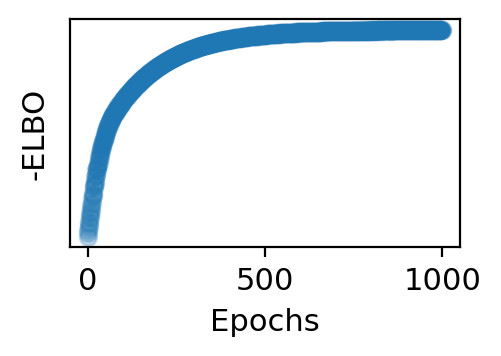

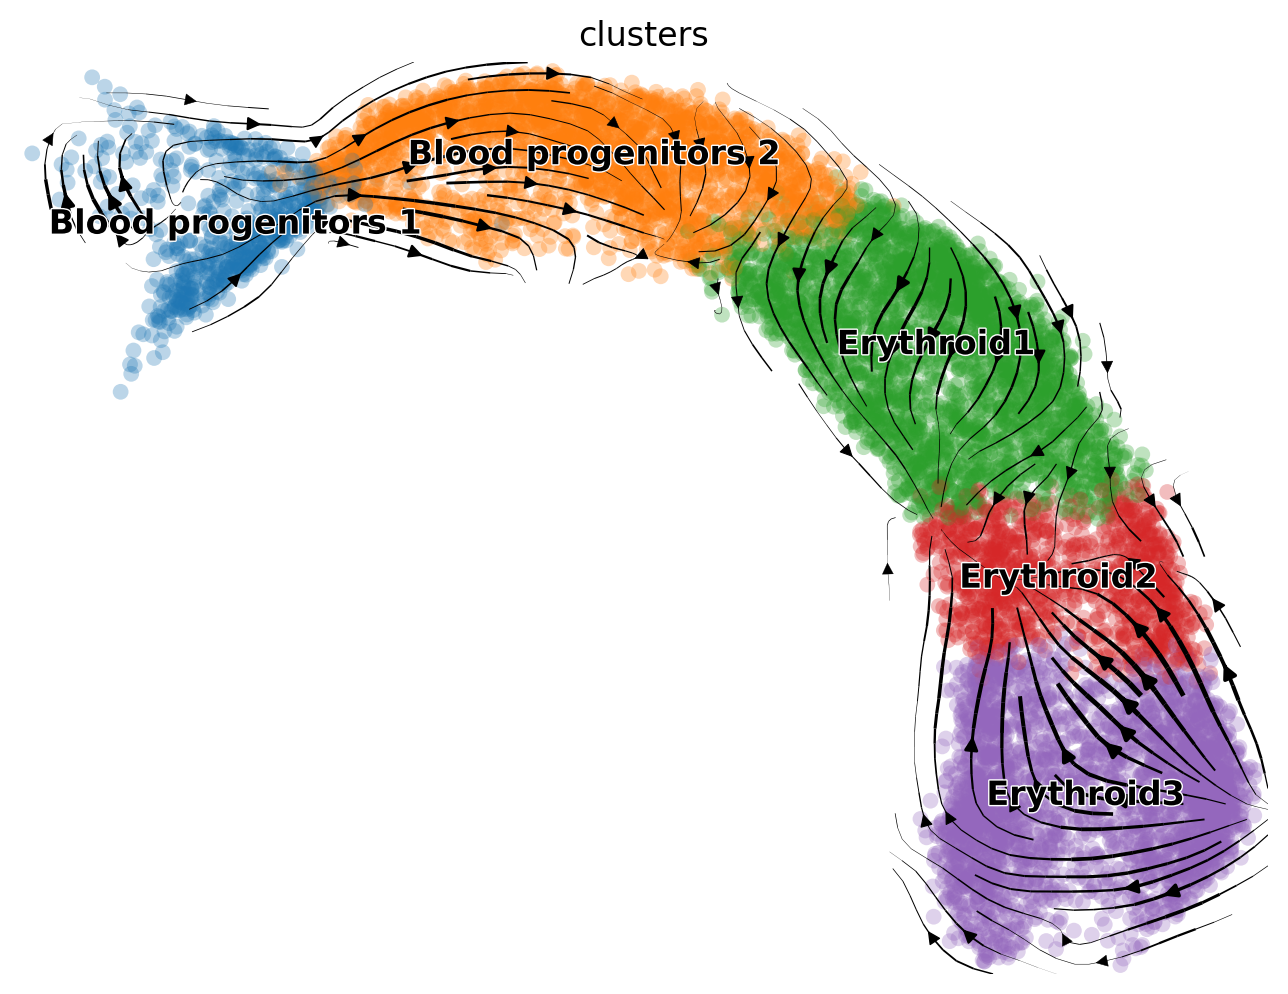

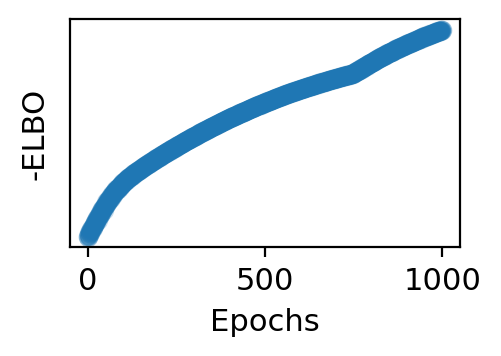

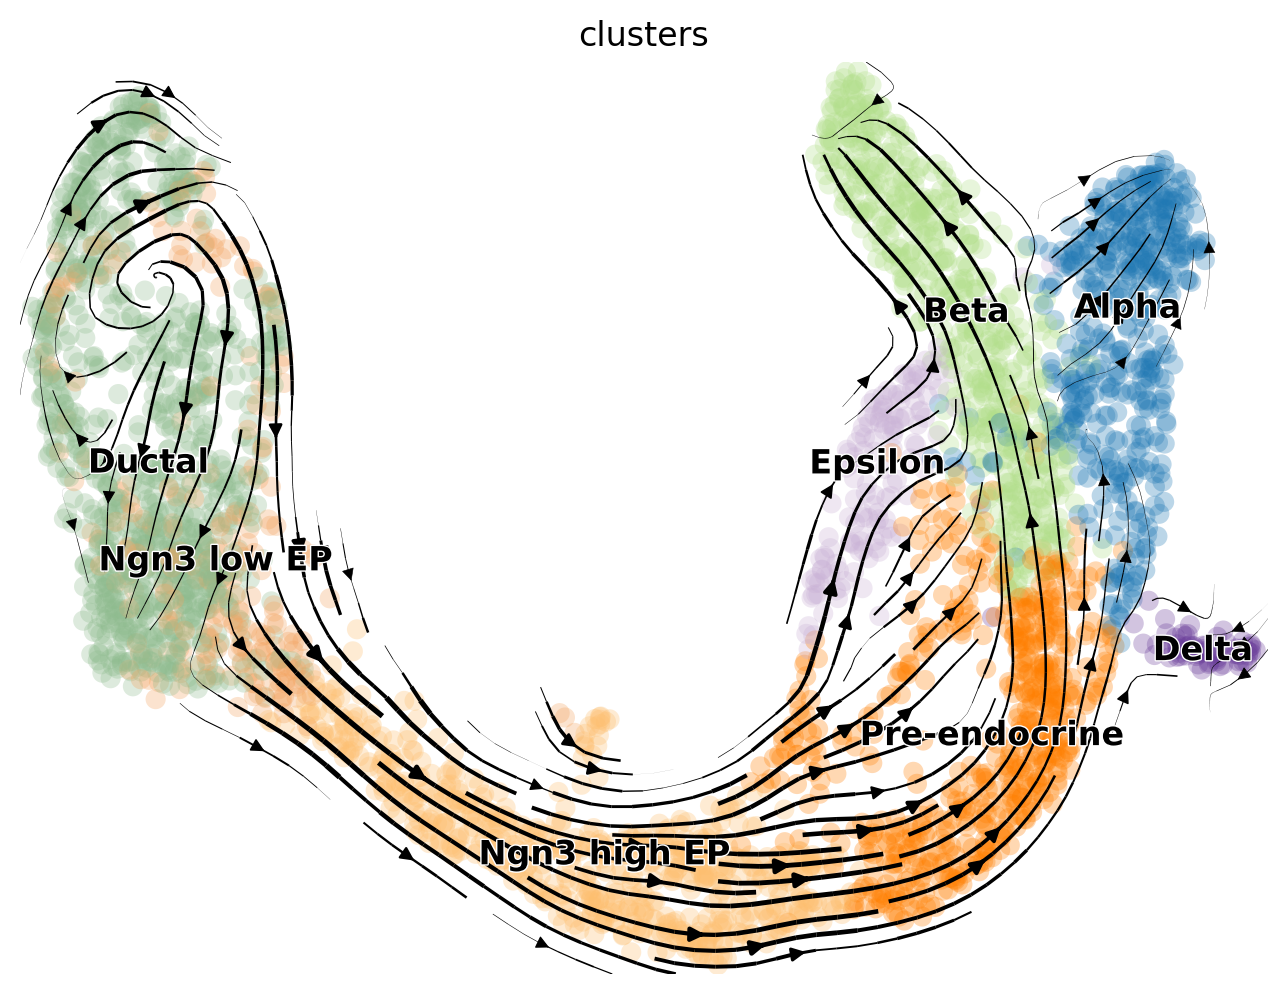

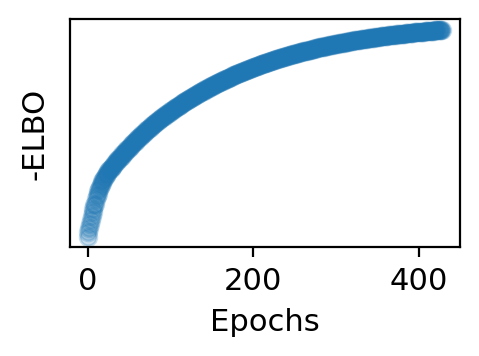

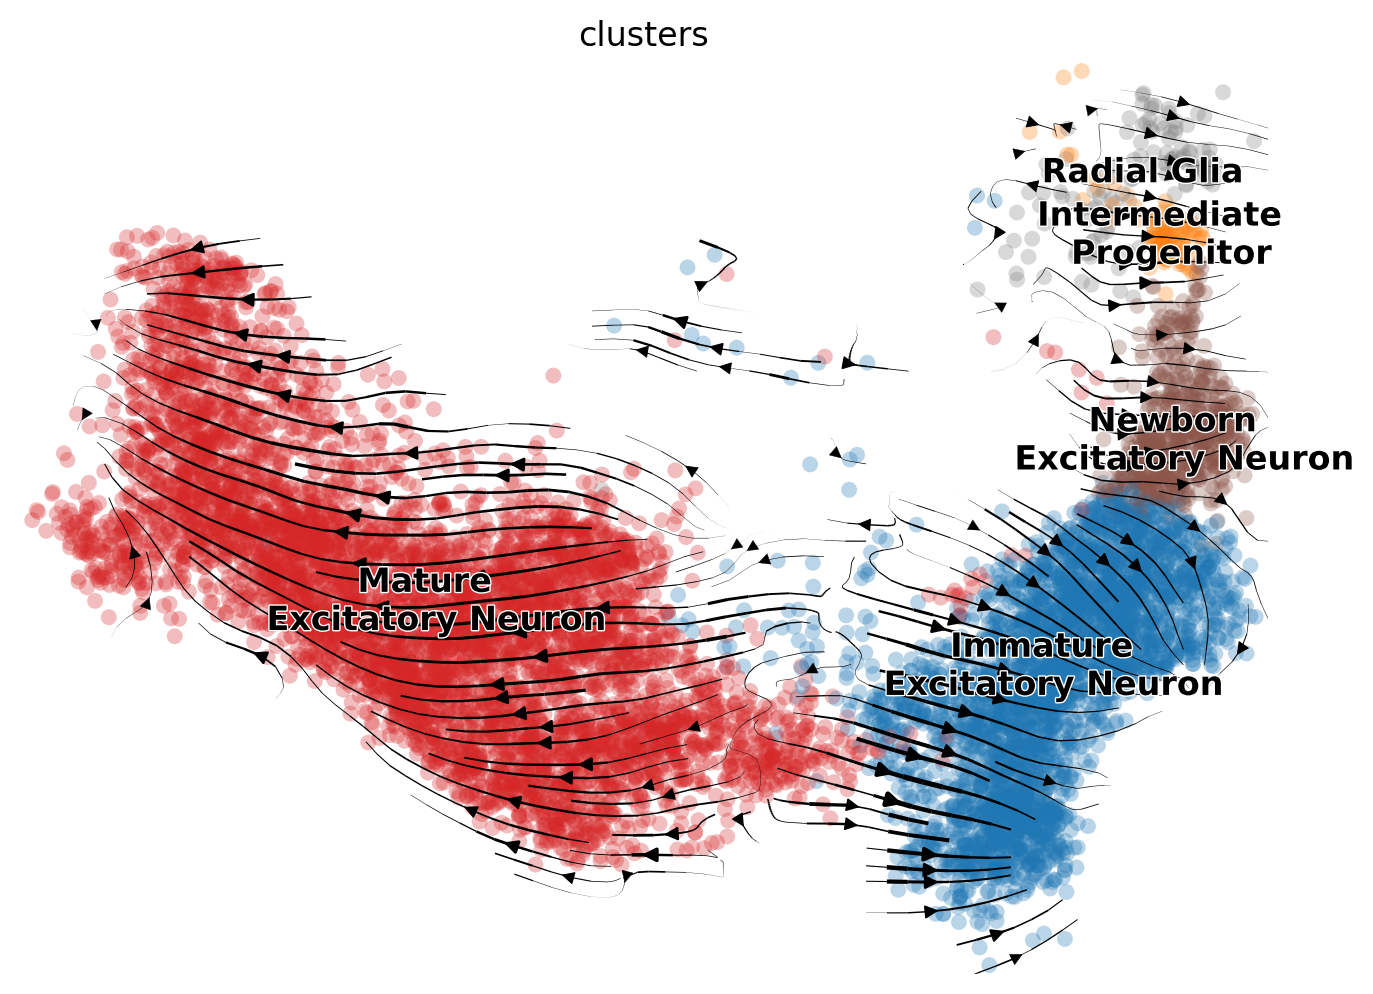

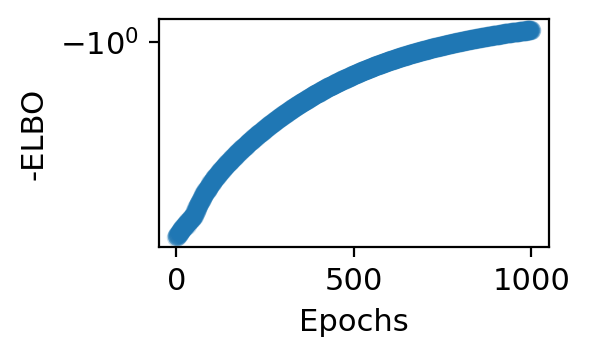

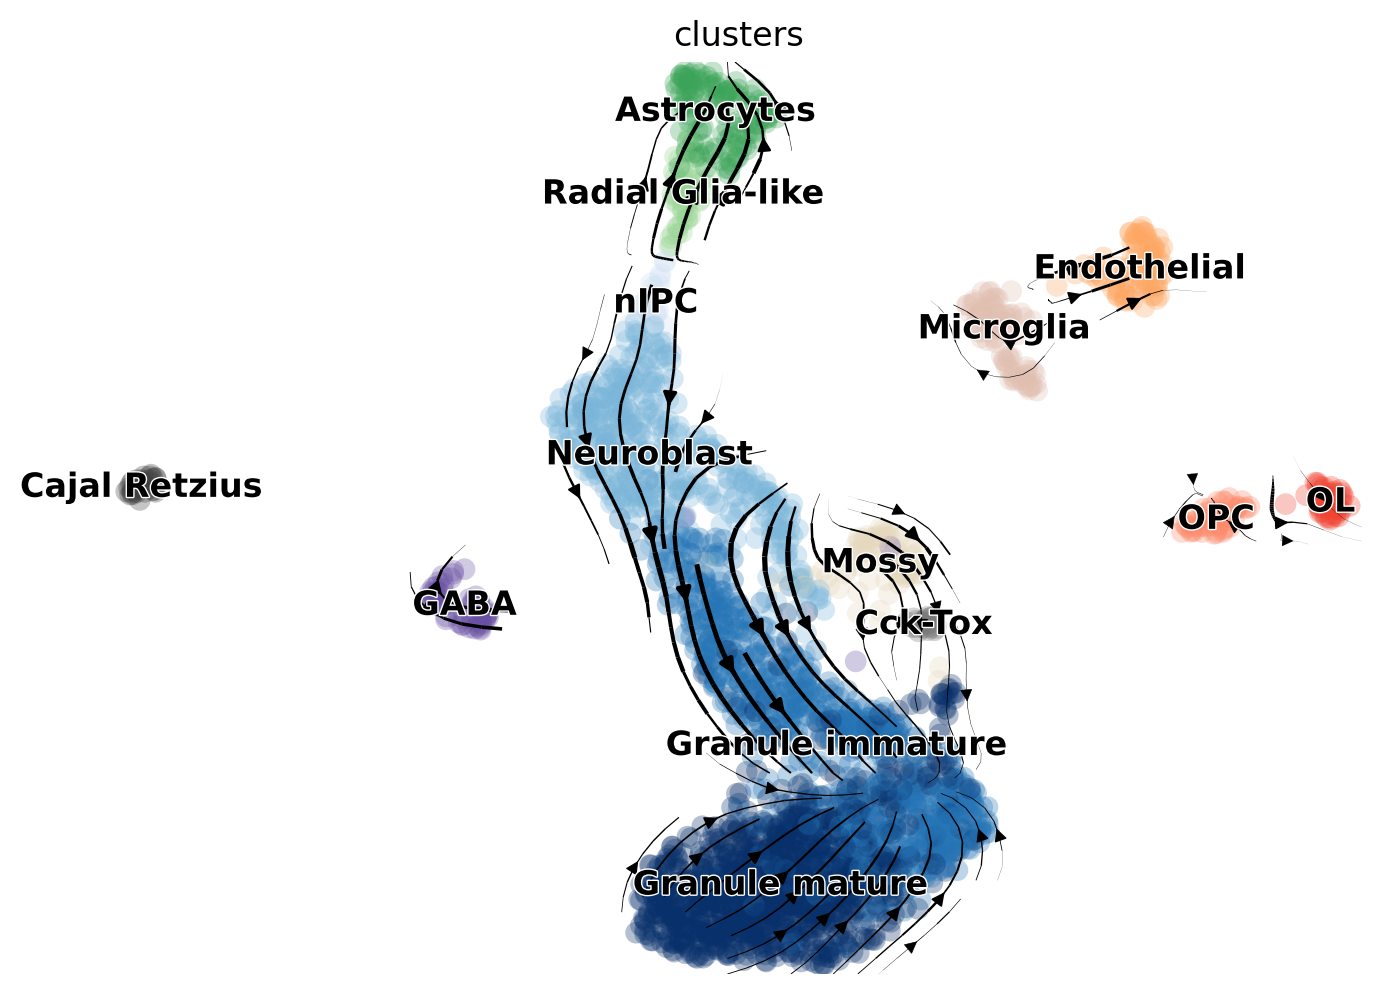

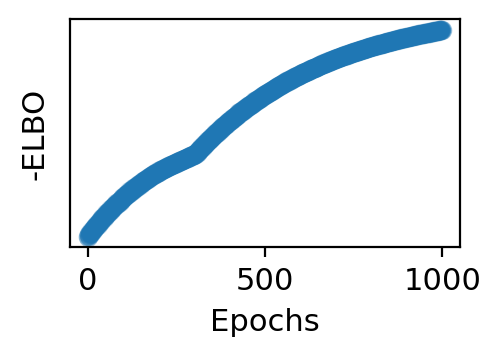

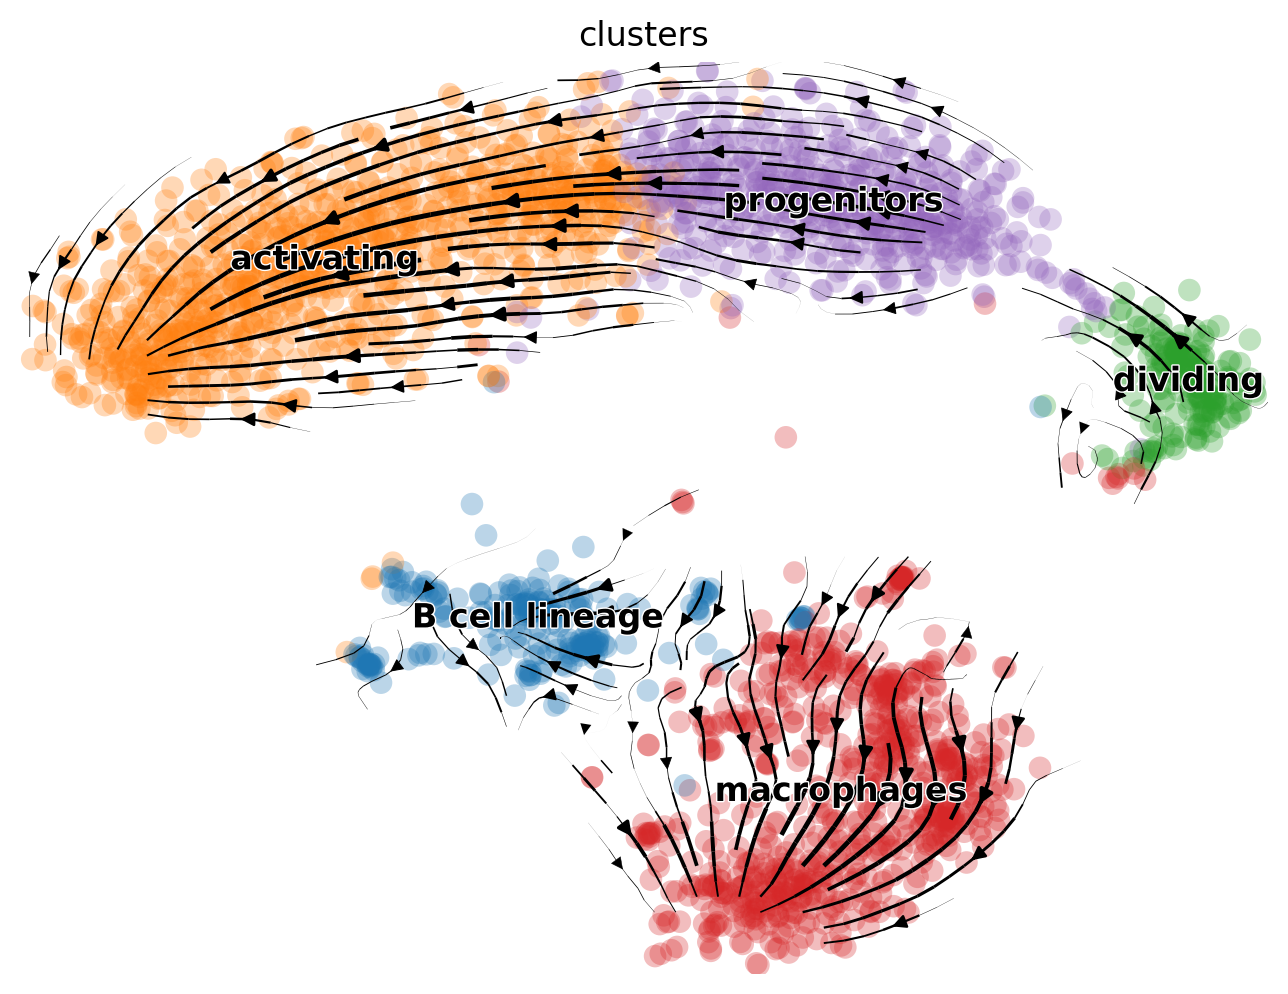

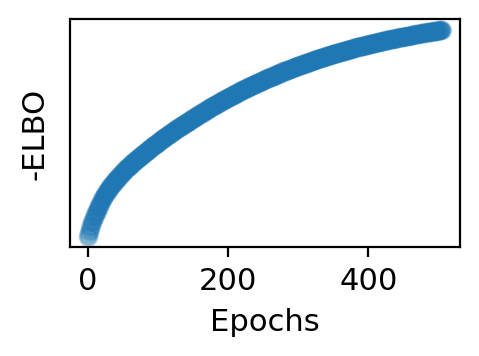

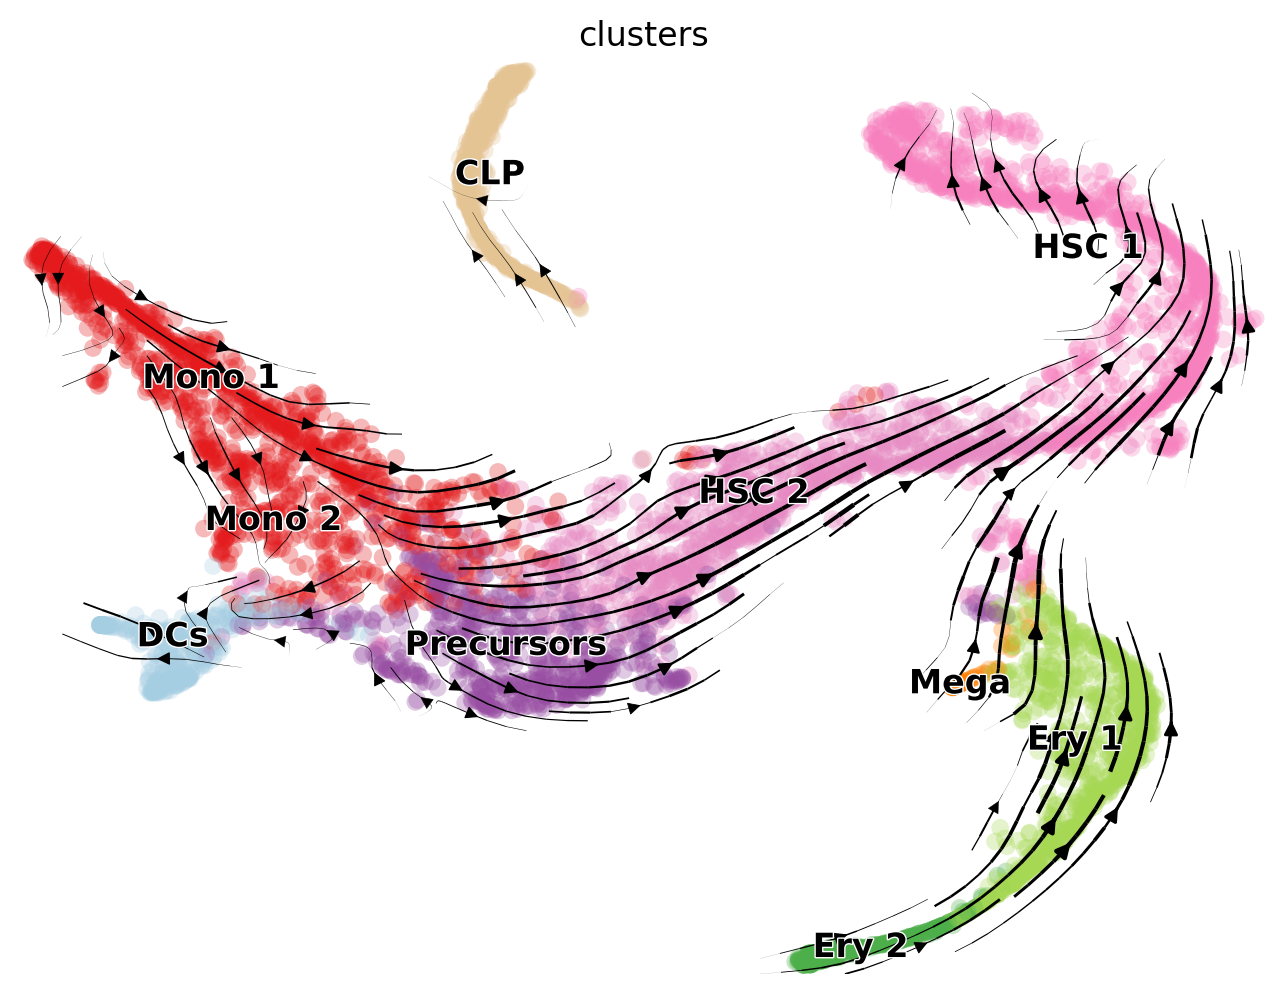

In [4]:
for dataset in datasets:
    print(dataset)
    adata = sc.read_h5ad(data_dir + dataset + '/' + dataset + '_anndata.h5ad')
    start = time.time()
    adata.layers['raw_spliced']   = adata.layers['spliced']
    adata.layers['raw_unspliced'] = adata.layers['unspliced']
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=3000)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    adata.obs['u_lib_size_raw'] = adata.layers['raw_unspliced'].toarray().sum(-1)
    adata.obs['s_lib_size_raw'] = adata.layers['raw_spliced'].toarray().sum(-1)
    # Model 1
    num_epochs = 1000 # large data
    adata_model_pos = train_model(adata,
                                   max_epochs=num_epochs, svi_train=True, log_every=100,
                                   patient_init=45,
                                   batch_size=4000, use_gpu=0, cell_state='state_info',
                                   include_prior=True,
                                   offset=True,
                                   library_size=True,
                                   patient_improve=1e-3,
                                   model_type='auto',
                                   guide_type='auto',
                                   train_size=1.0)
    compute_mean_vector_field(adata_model_pos[1], adata)
    end = time.time()
    scv.tl.velocity_graph(adata, vkey = 'velocity')
    scv.tl.velocity_embedding(adata, vkey = 'velocity')
    fix, ax = plt.subplots(1, 1, figsize = (8, 6))
    scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='velocity',
                                     show = False, ax = ax)
    plt.savefig(save_dir + 'UMAPs/' + dataset + '_UMAP_pyroVelocity_model2.svg')
    # Calculate performance metrics:
    file = open(data_dir + dataset + '/' + dataset + '_groundTruth.pickle' ,'rb')
    ground_truth = pickle.load(file)
    metrics = utv.evaluate(adata, ground_truth, 'clusters', 'velocity')
    if exists(save_dir + dataset + '_CBDC_scores.csv'):
        tab = pd.read_csv(save_dir + dataset + '_CBDC_scores.csv', index_col = 0)
    else:
        tab = pd.DataFrame(columns = list(metrics['Cross-Boundary Direction Correctness (A->B)'].keys()) + ['Mean', 'Time'],
                 index = [method])
    cb_score = [np.mean(metrics['Cross-Boundary Direction Correctness (A->B)'][x])
                for x in metrics['Cross-Boundary Direction Correctness (A->B)'].keys()]
    tab.loc[method,:] = cb_score + [np.mean(cb_score), end-start]
    tab.to_csv(save_dir + dataset + '_CBDC_scores.csv')
    plt.savefig(save_dir + 'UMAPs/' + dataset + '_UMAP_' + method + '.svg')
    adata.write_h5ad('/nfs/team283/aa16/data/fate_benchmarking/' + method + dataset + 'AnnDataForCellRank.h5ad')